# Imports

In [3]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline


# Instantiate batches

In [4]:
train_path = 'train'
valid_path = 'valid'
test_path = 'test'

In [5]:
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes=['Cow', 'Horse'], batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes=['Cow', 'Horse'], batch_size=8)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes=['Cow', 'Horse'], batch_size=20)

Found 80 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [6]:
ImageDataGenerator.__module__

'tensorflow.python.keras.preprocessing.image'

# Plot images with labels

In [11]:
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')


In [5]:
imgs, labels = next(train_batches)

C:\Users\Skip\Anaconda3\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


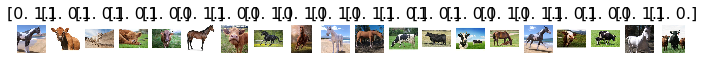

In [6]:
plots(imgs, titles=labels)

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Build Fine-tuned VGG16 model

In [8]:
vgg16_model = keras.applications.vgg16.VGG16()

In [9]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [10]:
type(vgg16_model)

tensorflow.python.keras.engine.functional.Functional

In [11]:
model = Sequential()
for layer in vgg16_model.layers[:-1]:
    model.add(layer)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

In [13]:
for layer in model.layers:
    layer.trainable = False

In [14]:
model.add(Dense(2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# Load model if needed

In [2]:
from tensorflow.keras.models import load_model
model = load_model('models/Cow_or_Horse_model_99.h5')

# Train the fine-tuned VGG16 Model

In [16]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.fit_generator(train_batches, steps_per_epoch=4, validation_data=valid_batches, validation_steps=4, epochs=5, verbose=2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
4/4 - 187s - loss: 0.2424 - accuracy: 0.8875 - val_loss: 0.6057 - val_accuracy: 0.7500
Epoch 2/5
4/4 - 171s - loss: 0.1968 - accuracy: 0.9250 - val_loss: 0.5383 - val_accuracy: 0.8125
Epoch 3/5
4/4 - 215s - loss: 0.1618 - accuracy: 0.9250 - val_loss: 0.4899 - val_accuracy: 0.8125
Epoch 4/5
4/4 - 209s - loss: 0.1358 - accuracy: 0.9375 - val_loss: 0.4591 - val_accuracy: 0.8125
Epoch 5/5
4/4 - 188s - loss: 0.1110 - accuracy: 0.9500 - val_loss: 0.4408 - val_accuracy: 0.8125


# Predict using fine-tuned VGG16 model

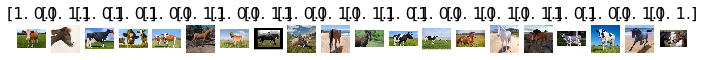

In [14]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles=test_labels)

In [15]:
test_labels = test_labels[:,0]
test_labels

array([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1.,
       1., 0., 0.], dtype=float32)

In [9]:
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

Instructions for updating:
Please use Model.predict, which supports generators.


In [16]:
cm = confusion_matrix(test_labels, np.round(predictions[:,0]))

Confusion matrix, without normalization
[[5 5]
 [3 7]]


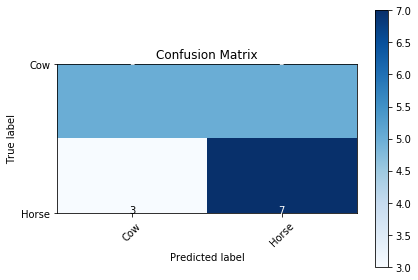

In [19]:
cm_plot_labels = ['Cow','Horse']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [23]:
predictions


array([[5.9226924e-01, 4.0773073e-01],
       [9.8662609e-01, 1.3373884e-02],
       [9.9226272e-01, 7.7372766e-03],
       [2.2117329e-01, 7.7882665e-01],
       [4.7833565e-01, 5.2166426e-01],
       [4.6724132e-01, 5.3275871e-01],
       [9.9963689e-01, 3.6312192e-04],
       [8.9171566e-02, 9.1082847e-01],
       [5.0502932e-01, 4.9497065e-01],
       [1.3970086e-01, 8.6029911e-01],
       [8.2996182e-02, 9.1700381e-01],
       [7.3654640e-01, 2.6345360e-01],
       [5.6478664e-02, 9.4352138e-01],
       [9.9626452e-01, 3.7355090e-03],
       [1.1711131e-02, 9.8828888e-01],
       [5.0940257e-01, 4.9059749e-01],
       [6.4744301e-02, 9.3525577e-01],
       [9.3681490e-01, 6.3185111e-02],
       [9.9730444e-01, 2.6955879e-03],
       [9.9481827e-01, 5.1817107e-03]], dtype=float32)

# Save the model

In [20]:
import os.path
if os.path.isfile('models/Cow_or_Horse_model.h5') is False:
    model.save('models/Cow_or_Horse_model.h5')

# Load the model

In [21]:
from tensorflow.keras.models import load_model
new_model = load_model('models/Cow_or_Horse_model.h5')


In [22]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2